In [163]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

data = pd.read_csv("../data/Default.csv")

data.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [165]:
data.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [166]:
data["default"].value_counts(), data["student"].value_counts()

(default
 No     9667
 Yes     333
 Name: count, dtype: int64,
 student
 No     7056
 Yes    2944
 Name: count, dtype: int64)

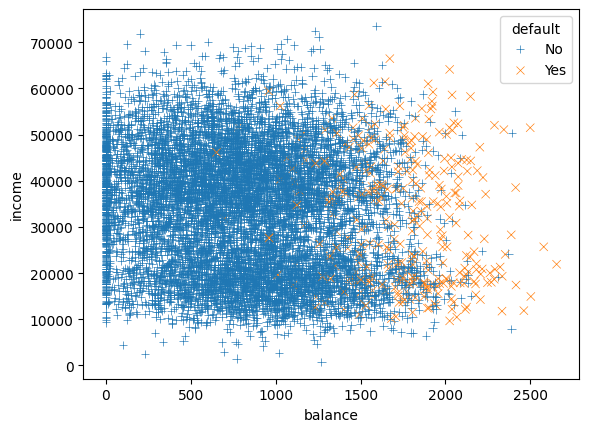

In [167]:
sns.scatterplot(data=data, x="balance", y="income", style="default", markers=["+", "x"], hue="default")
plt.show()

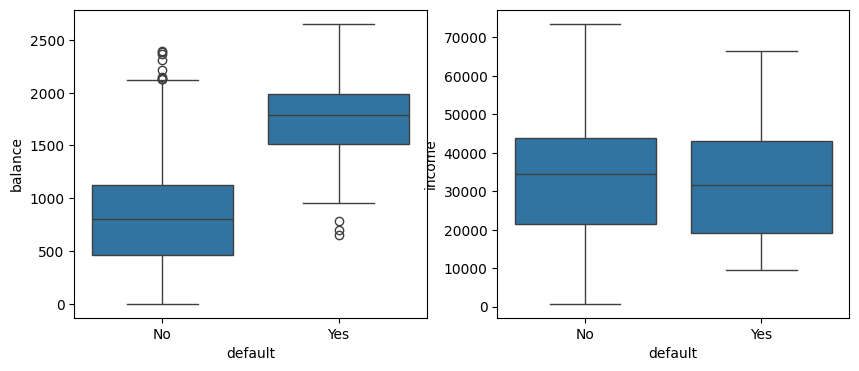

In [168]:
fig, ax = plt.subplots(1,2, dpi=100, figsize=(10,4))

for axi, col in zip(ax, ["balance", "income"]):
    sns.boxplot(data=data, x="default", y=col, ax=axi)

Dom kategoriska varibaler förstår inte modellen vad det menas. Man behöver koda det som siffror, för att representera katogorierna. 

In [169]:
data = pd.get_dummies(data, columns=["default", "student"], drop_first=True)

data.head()

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,False,False
1,817.180407,12106.134700,False,True
2,1073.549164,31767.138947,False,False
3,529.250605,35704.493935,False,False
4,785.655883,38463.495879,False,False


Nu tittar vi på sannolikheter på om det är True or False för vad vi söker i datan. Om tillexempel här hur stor sannolikheten en person kommer betala sina lån eller inte. Så vi behöver en funktion som ger en sannolikhetsfördelning. 

Text(0.5, 1.0, 'Logistic function')

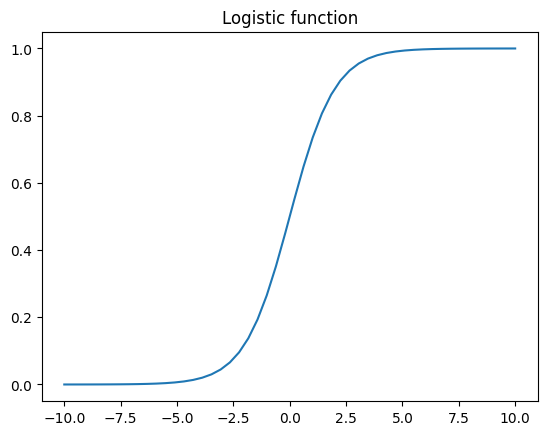

In [170]:
logistic_function = lambda x: np.exp(x)/(1+np.exp(x))

x = np.linspace(-10, 10)
plt.plot(x, logistic_function(x))
plt.title("Logistic function")

### Odds

A convenient way to talk about how a variable relates to another one is to use odds ratio, which is a statistics that can vary from 0 to $\infty$. The odds of a default vs not a default is given by this fraction of probability: 

$$\frac{p(X)}{1-p(X)} = e^{\beta_0+\beta_1X}$$

For example on average 3 of 10 gets a default is given by $0.3/0.7 = 3/7$.

We take logarithm of both sides and obtain the log odds or logit

$$\log{\left(\frac{p(X)}{1-p(X)} \right)} = \beta_0 + \beta_1X$$

This model is linear in $X$ and the parameters $\beta_0, \beta_1$ are chosen to maximize the likelihood function

$$l(\beta_0, \beta_1) = \prod_{y_i = 1}p(x_i)\prod_{y_j=0}(1-p(x_j))$$

In practice the log likelihood function is maximized using an optimization alogrithm such as batch gradient descent, mini-batch gradient descent or stochastic gradient descent.  

In [171]:
X, y = data.drop("default_Yes", axis=1), data["default_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

model = LogisticRegression(penalty=None)

model.fit(scaled_X_train, y_train)
model.coef_


array([[ 2.88848257,  0.00619039, -0.29011374]])

In [172]:
test_sample = pd.DataFrame({"balance": [1500, 1500], "income": [
                           40000, 40000], "student_Yes": [1, 0]})

print(test_sample)
# only difference is that one is student and the other is not
scaled_test_sample = scaler.transform(test_sample)

# first column is -1 label i.e. not default, second column is label 1 i.e. default
model.predict_proba(scaled_test_sample)
# we see that being student decreases the chance of getting default b

   balance  income  student_Yes
0     1500   40000            1
1     1500   40000            0


array([[0.94488091, 0.05511909],
       [0.90077997, 0.09922003]])

In [173]:
y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_probability[:5]

array([[9.30371604e-01, 6.96283964e-02],
       [9.98550654e-01, 1.44934591e-03],
       [9.99985392e-01, 1.46075512e-05],
       [9.99971155e-01, 2.88449734e-05],
       [9.54564556e-01, 4.54354445e-02]])

---

## Evaluation metrics for classification

Confusion matrix

||Pos prediction|Neg prediction|
|---|---|---|
|Pos class|TP|FN|
|Neg class|FP|TN|

- accuracy - ratio of correct predictions to all predictions
    - bad measure when, dataset class is imbalanced, e.g. a fraud model that always predicts non fraudulent could achieve accuracy of close to 1 without having any predictive power. 
- precision - number of positive class predictions that belong to positive class
    - good measure when FP is allowed to be higher e.g. email spam classification 
- recall - sensitivity - number of positive class predictions out of all positive examples 
    - good measure when there is high cost with FN e.g. sick patient of a contageous disease such as Covid-19 quick test
- $F_1$ score - harmonic mean between precision and recall 
    - seeks a balance between precision, recall and uneven class distributions

$ acc = \frac{TP+TN}{Total} $

$ prec = \frac{TP}{TP+FP}$

$ rec = \frac{TP}{TP+FN}$

$ F_1 = 2\frac{prec\cdot recall}{prec + rec}$

Accuraaccy: 0.973


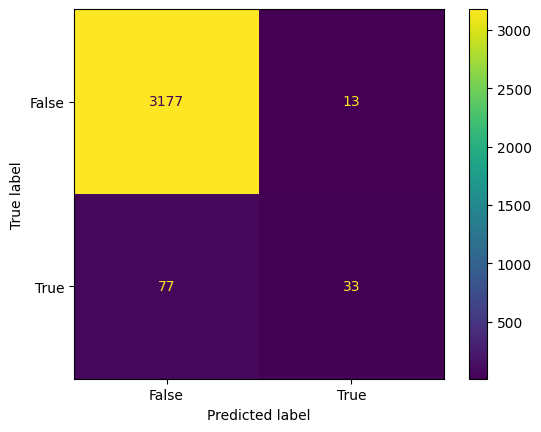

In [174]:
y_pred = model.predict(scaled_X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuraaccy: {acc:.3f}")

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp=ConfusionMatrixDisplay(cm, display_labels=model.classes_)
disp.plot()

In [175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3190
        True       0.72      0.30      0.42       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300



Det är ett stort problem i ett obalnserat data set, för det blir enelt att bara gissa på där ovikten pippar tungt. Med andra ord man kan bortse fron sanna fel. Är inte helt enkelt att balanera data, för det kan lägga för stor sannolikheter på vad som egentligen har signifikans. Att data faktis vissar på ett samband, som kna bli vridigt svaret snett. 